# Data Summary 

This notebook describes distributions in the data. 

**Import the data and split it into bins**: 

In [1]:
import os, re
import numpy as np
import pandas as pd  

from student_voices import visuals
from student_voices.sv_utils import loosen, decompress_pickle, full_value_count

In [2]:
# Import the data
data = decompress_pickle('C:/Projects/VirtualMachines/Student_Voices/svvm/Student_Voices/student_voices/data/review_stats.pbz2')

## <font color=darkblue>Distribution by Rating Level</font>

The following blocks show summary stats for the number of reviews in each ratings bin.

In [3]:
# Change the ratings to a 0-100 measure
data['Rating'] = ((data['Rating'] - data['Rating'].min())/ (data['Rating'].max()-data['Rating'].min()))*100

# Use these preset levels to split the ratings into groups of similar size. 
data['Bins'] = pd.cut(data['Rating'], bins=[-1,35,58,65,75,85,95,101])

In [5]:
full_value_count(data,'Bins')

,Bins_#,Bins_%
"(-1, 35]",359387,0.073887
"(35, 58]",309850,0.063703
"(58, 65]",244504,0.050268
"(65, 75]",248963,0.051185
"(75, 85]",404741,0.083212
"(85, 95]",593581,0.122036
"(95, 101]",2702952,0.555708


**Distribution after restricting review length:**

In [12]:
site_data = data[data['Review_Length']>=100]

In [13]:
full_value_count(site_data,'Bins')

,Bins_#,Bins_%
"(-1, 35]",212784,0.089773
"(35, 58]",176430,0.074435
"(58, 65]",118137,0.049842
"(65, 75]",136812,0.057721
"(75, 85]",192688,0.081294
"(85, 95]",328942,0.138780
"(95, 101]",1204455,0.508156


**Visualize the distribution of reviews by rating levels**:

As we restrict the number of reviews teachers are required to have to be included in the dataset, the ratings distribution does not vary much. 

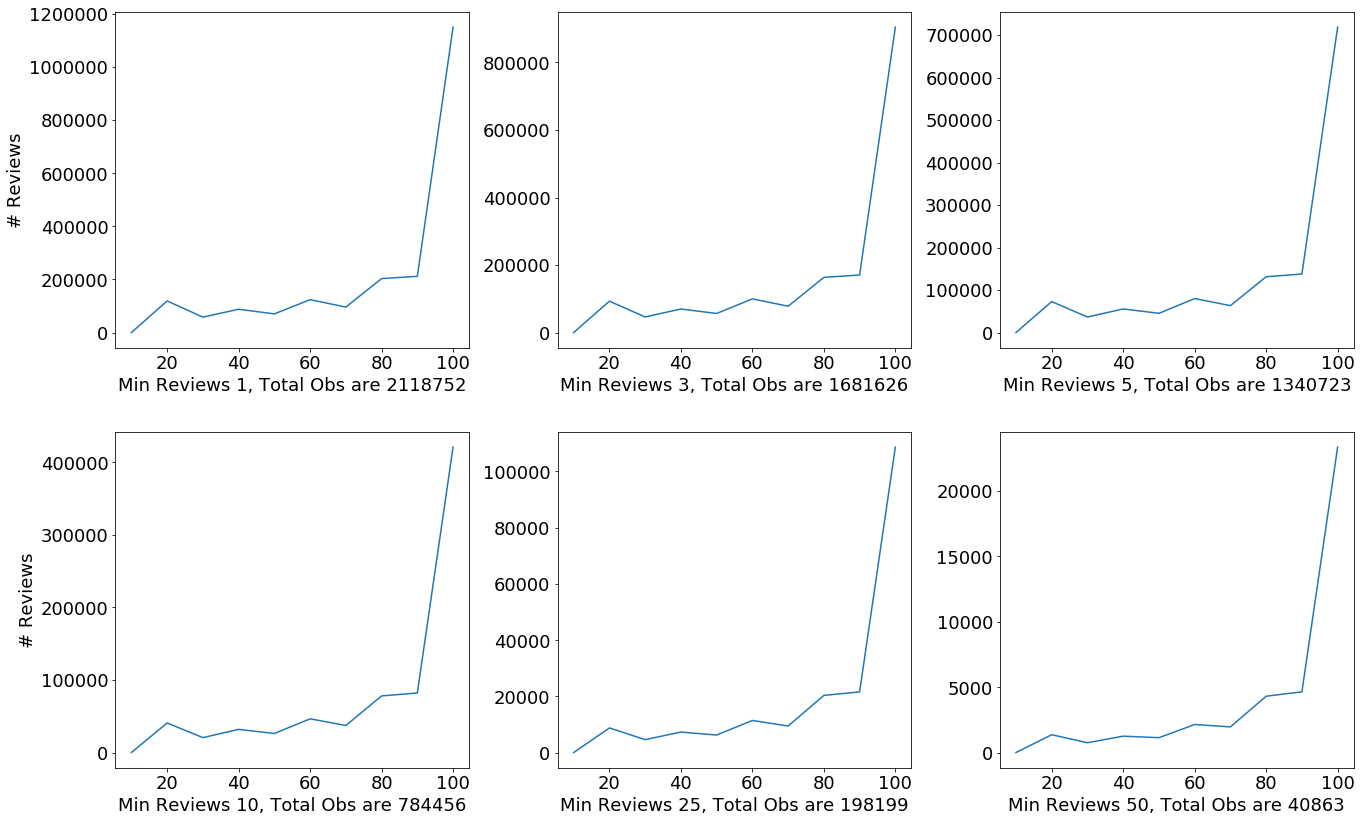

In [29]:
visuals.plot_restricted_review_dists(data, save='C:\\Projects\\VirtualMachines\\Student_Voices\\svvm\\Student_Voices\\graphs/ratings_dist_by_min_reviews.png')

In [30]:
# fig = visuals.plot_cumulative_rating_dist(site_data)
# fig.show()

In [31]:
# fig = visuals.plot_rating_dist(site_data)
# fig.show()

## <font color=darkblue>Submitted By</font>

A number of other sub-sample can be created and explored. For example, after 2015 the website began providing reviewers the option to identify as parents or students so for a minority of reviews we can observe this distinction. 

In [16]:
data['SubmittedBy'].value_counts()

Submitted by a student    355399
Submitted by a Parent      15620
Name: SubmittedBy, dtype: int64

## <font color=darkblue>School Descriptions </font>

School descriptions pulled from RMT also contain useful information about the schools so we extract that into separate variables that we can review. These show that most reviews come from reviewers addressing middle or highschool teachers. This is in line with the low proportion of parents who submit reviews since, in elementary school it would likely be the parents who would submit reviews. 

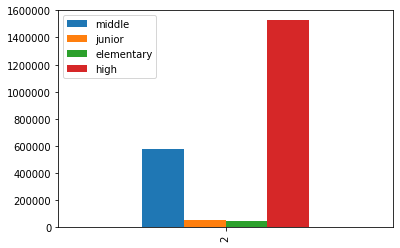

In [23]:
des = pd.read_csv('C:/Projects/VirtualMachines/Student_Voices/svvm/Student_Voices/student_voices/data/school_database.csv')

# remove unnecesary columns 
des = des[[c for c in des.columns if 'Unnamed' not in c]]

# identify school types 
des['public'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Pp]ublic[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['middle'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Mm]iddle[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['junior'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Jj]unior', d.split(',')[0])) else 0)
des['elementary'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Ee]lementary[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['high'] = des['school_description'].apply(lambda d: 1 if len(re.findall('(?<!unior) [Hh]igh[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)

# gender distribution 
des['male'] = des['gender'].apply(lambda s: int(re.findall(r'([0-9]*) Male', str(s))[0]) if len(re.findall(r'([0-9]*) Male', str(s)))>0 else np.NaN)
des['female'] = des['gender'].apply(lambda s: int(re.findall(r'([0-9]*) Female', str(s))[0]) if len(re.findall(r'([0-9]*) Male', str(s)))>0 else np.NaN)

# students enrolled 
des['student'] = des['student'].apply(lambda s: re.findall(r'[0-9]*', str(s).replace(',',''))[0] if len(re.findall(r'[0-9]*',str(s)))>0 else np.NaN)
des['student'] = pd.to_numeric(des['student'], errors='coerce')

lvl_dist = pd.merge(data[['Rating','School']],
                    des[['School','middle','junior','elementary','high']],
                    on = 'School', 
                    how = 'outer',
                    indicator = True) 

dist = lvl_dist.groupby('_merge', as_index = False)[['middle','junior','elementary','high']].sum()
dist = dist[dist['_merge'] == 'both'].drop('_merge', 1)
dist.plot.bar()

### Creating Categorical Labels 

Above we saw that there is some consistency in the data. Now we will process the likert scale data submitted by reviewers. The characteristics rated are listed below. In this first block we check how the data is present by year. As can be seen in the table, only `Clarity`, `Easiness`, and `Helpfulness` are present in every year of the data. ` Knowledge` is available from 2011, `Exam Difficulty` and `Textbook Use` are present from 2013, and the rest are available starting 2015. 

In [ ]:
# Create dummy variables for year to illustrate data availability over time 
catdata=pd.concat([data,
                pd.get_dummies(data['DateTime'].apply(lambda x: x.split('-')[0]),
                               prefix='Year')],
                axis = 1)

characteristics = ['Clarity','Easiness','Exam Difficulty','Helpfulness','Knowledge','Textbook Use','Determination','Effective','Empathy','Homework','Integrity','Parent Relation','Respect']

# Show the availability of variables across years 
yvars = [c for c in catdata.columns if 'Year_' in c]
yvars = list(set(yvars))
corrs = catdata[characteristics + yvars].corr()
corrs = corrs.corr()

In [61]:
(corrs.notnull()).astype(int).loc[yvars,characteristics]

,Clarity,Easiness,Exam Difficulty,Helpfulness,Knowledge,Textbook Use,Determination,Effective,Empathy,Homework,Integrity,Parent Relation,Respect
Year_2001,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2002,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2003,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2004,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2005,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2006,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2007,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2008,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2009,1,1,0,1,0,0,0,0,0,0,0,0,0
Year_2010,1,1,0,1,0,0,0,0,0,0,0,0,0


**Viewing distribution of characteristics:**

In [102]:
tables = []
for c in characteristics:  
    t = pd.DataFrame(data[c].value_counts()).sort_index(ascending=False)
    t.loc['total'] = t.sum()
    t = pd.DataFrame(t.apply(lambda x: "{:,}".format(x[c]), axis=1), columns=[c])
    tables.append(t)
visuals.display_side_by_side(tables)

,Clarity
5.0,"2,973,130"
4.0,"780,688"
3.0,"465,739"
2.0,"272,943"
1.0,"348,314"
total,"4,840,814"
,Easiness
5.0,"1,905,620"
4.0,"945,497"
3.0,"1,164,881"


## Cluster Analaysis of Characteristics 

Because we have likert scale data we can't simply classify something as easy or difficult, there are degrees. Textbook Use, Parent Relation, things start getting complicated and that's before accounting for data availability. 

In [117]:
ct = data[characteristics].notnull().astype(int)

In [129]:
ct.corr()

,Clarity,Easiness,Exam Difficulty,Helpfulness,Knowledge,Textbook Use,Determination,Effective,Empathy,Homework,Integrity,Parent Relation,Respect
Clarity,1.0,0.9811076951999522,0.025713905554419998,0.9825544409247622,0.032887837848813946,0.026231948124779757,-0.9810192980815532,-0.9810192980815532,-0.9810192980815532,-0.9810192980815532,-0.9810192980815532,-0.9810192980815532,-0.9810192980815532
Easiness,0.9811076951999522,1.0,0.028165983940625847,0.9901898464223357,0.035949755251867284,0.028130192711271377,-0.9999099008134222,-0.9999099008134222,-0.9999099008134222,-0.9999099008134222,-0.9999099008134222,-0.9999099008134222,-0.9999099008134222
Exam Difficulty,0.025713905554419998,0.028165983940625847,1.0,0.026648917579543997,0.7826030918469121,0.9974733371103349,-0.02816344620783953,-0.02816344620783953,-0.02816344620783953,-0.02816344620783953,-0.02816344620783953,-0.02816344620783953,-0.02816344620783953
Helpfulness,0.9825544409247622,0.9901898464223357,0.026648917579543997,1.0,0.034659341385364015,0.026858239059500872,-0.9901006312368291,-0.9901006312368291,-0.9901006312368291,-0.9901006312368291,-0.9901006312368291,-0.9901006312368291,-0.9901006312368291
Knowledge,0.032887837848813946,0.035949755251867284,0.7826030918469121,0.034659341385364015,1.0,0.7818329440504537,-0.03594651620336405,-0.03594651620336405,-0.03594651620336405,-0.03594651620336405,-0.03594651620336405,-0.03594651620336405,-0.03594651620336405
Textbook Use,0.026231948124779757,0.028130192711271377,0.9974733371103349,0.026858239059500872,0.7818329440504537,1.0,-0.02812765820192464,-0.02812765820192464,-0.02812765820192464,-0.02812765820192464,-0.02812765820192464,-0.02812765820192464,-0.02812765820192464
Determination,-0.9810192980815532,-0.9999099008134222,-0.02816344620783953,-0.9901006312368291,-0.03594651620336405,-0.02812765820192464,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Effective,-0.9810192980815532,-0.9999099008134222,-0.02816344620783953,-0.9901006312368291,-0.03594651620336405,-0.02812765820192464,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Empathy,-0.9810192980815532,-0.9999099008134222,-0.02816344620783953,-0.9901006312368291,-0.03594651620336405,-0.02812765820192464,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Homework,-0.9810192980815532,-0.9999099008134222,-0.02816344620783953,-0.9901006312368291,-0.03594651620336405,-0.02812765820192464,1.0,1.0,1.0,1.0,1.0,1.0,1.0


From the above data we can see that the website changed its survey mechanism over time. Since different characteristics were available at different times we should evaluate how we group them together before analyzing them. The groups are: 

<br>**Group 1**: Clarity, Easiness, Helpfullness - These seem to always have been present along side eachother. 
<br>**Group 2**: Knowledge, Exam Difficulty, Textbook Use - These pop up for a bit along side the above. 
<br>**Group 3**: 1 & 2 - These will be a small subset of Group 1. 
<br>**Group 4**: Determination, Effective, Empathy, Homework, Integrity, Parent Relation, Respect. 

In [4]:
group_1 = ['Clarity','Easiness','Helpfulness']
group_2 = ['Knowledge','Exam Difficulty','Textbook Use']
group_3 = ['Clarity','Easiness','Helpfulness','Knowledge','Exam Difficulty','Textbook Use']
group_4 = ['Determination','Effective','Empathy','Homework','Integrity','Parent Relation','Respect']

group_1_data = data[data[group_1].notnull().astype(int).sum(axis=1)==3]
group_2_data = data[data[group_2].notnull().astype(int).sum(axis=1)==3]
group_3_data = data[data[group_3].notnull().astype(int).sum(axis=1)==6]
group_4_data = data[data[group_4].notnull().astype(int).sum(axis=1)==7]

print('Length of group 1 data is ', str(len(group_1_data)))
print('Length of group 2 data is ', str(len(group_2_data)))
print('Length of group 3 data is ', str(len(group_3_data)))
print('Length of group 4 data is ', str(len(group_4_data)))

Length of group 1 data is  4840625
Length of group 2 data is  711911
Length of group 3 data is  711598
Length of group 4 data is  22297


In [5]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [6]:
X = StandardScaler().fit_transform(group_2_data[group_2].values)

In [ ]:
%%time

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=1000).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [164]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 22
Homogeneity: 0.947
Completeness: 0.868
V-measure: 0.906
Adjusted Rand Index: 0.943
Adjusted Mutual Information: 0.867
Silhouette Coefficient: 0.621


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


C:\Users\Computer\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



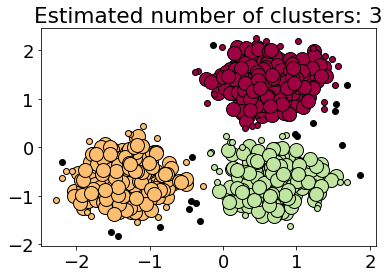

In [103]:
print(__doc__)





print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()